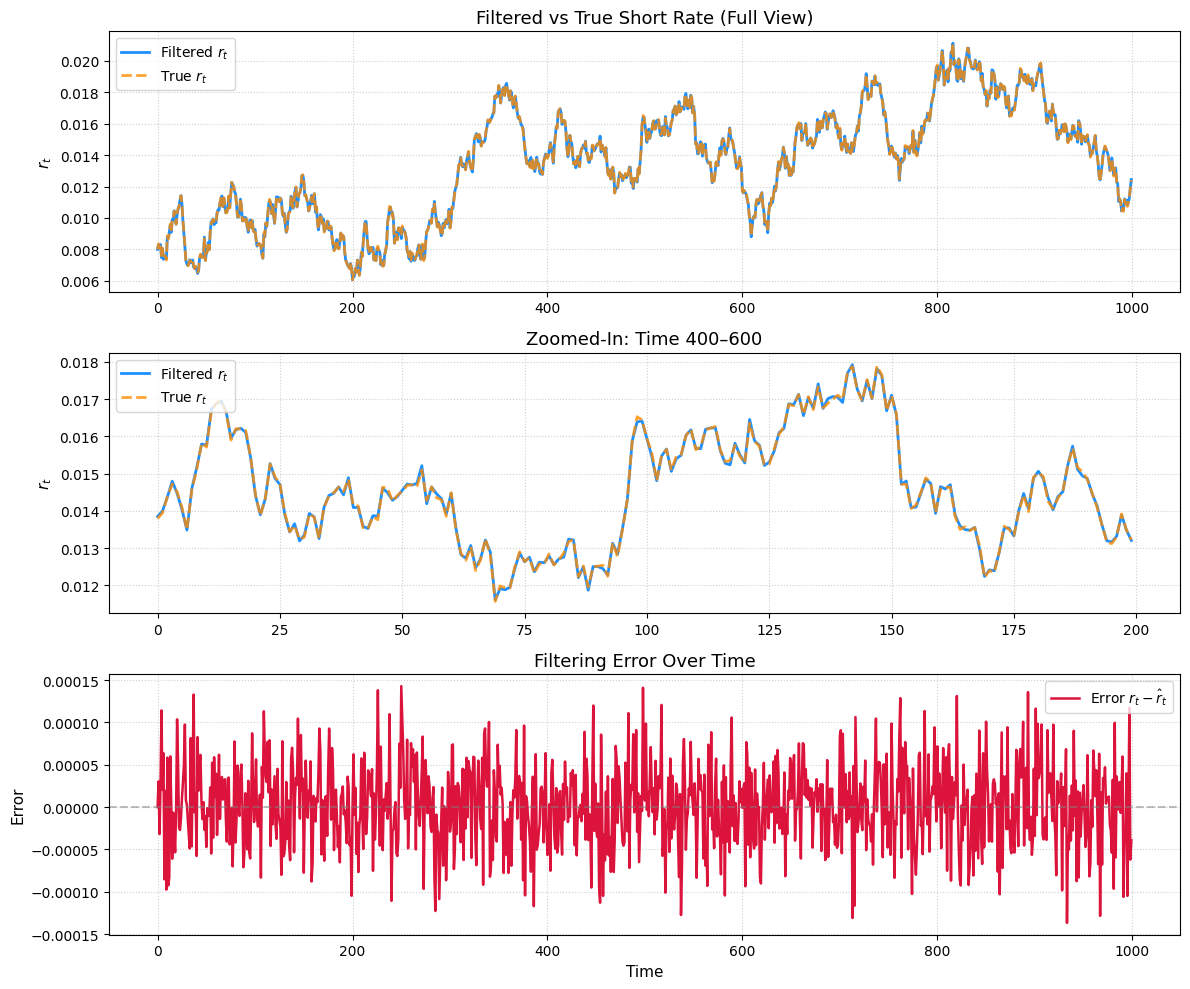

In [1]:
import numpy as np

# --- PARAMETERS ---
nobs = 1000
r0 = 0.008
np.random.seed(12)

alpha_P = 0.018
theta_P = 0.014
alpha_Q = 0.017
theta_Q = 0.016
sigma = 0.0005
sigma_y = 0.0001
maturities = np.array([1, 6, 12, 36, 60, 120])  # in months

# --- 1) SIMULATE SHORT RATE r_t UNDER P MEASURE ---
r_t = np.zeros(nobs)
r_t[0] = r0
phi = np.exp(-alpha_P)
c = theta_P * (1 - phi)
q = np.sqrt((sigma ** 2) / (2 * alpha_P) * (1 - np.exp(-2 * alpha_P)))

for t in range(1, nobs):
    r_t[t] = c + phi * r_t[t - 1] + q * np.random.randn()

# --- 2) COMPUTE VASICEK YIELDS UNDER Q MEASURE ---
B_tau = (1 - np.exp(-alpha_Q * maturities)) / alpha_Q
A_tau = ((theta_Q - (sigma ** 2) / (2 * alpha_Q ** 2)) * (B_tau - maturities)
         - (sigma ** 2) * (B_tau ** 2) / (4 * alpha_Q))

# Clean yields: y_tau = -(A_tau - B_tau * r_t) / tau
yields_clean = np.zeros((nobs, len(maturities)))
for i, tau in enumerate(maturities):
    yields_clean[:, i] = -(A_tau[i] - B_tau[i] * r_t) / tau

# --- 3) ADD MEASUREMENT NOISE ---
yields_obs = yields_clean + np.random.normal(0, sigma_y, size=yields_clean.shape)

# --- 4) KALMAN FILTER FUNCTION ---
def kalmanFilter(yields, a, B, H, c, Phi, Q):
    T = yields.shape[0]
    n_obs = yields.shape[1]

    r_pred = np.zeros(T)
    r_filt = np.zeros(T)
    P_pred = np.zeros(T)
    P_filt = np.zeros(T)
    log_likelihood = 0.0

    r_filt[0] = r0
    P_filt[0] = 1e-5

    B = B.reshape(-1, 1)
    a = a.reshape(-1)

    for t in range(1, T):
        # Predict step
        r_pred[t] = c + Phi * r_filt[t - 1]
        P_pred[t] = Phi * P_filt[t - 1] * Phi + Q**2

        # Observation prediction
        y_hat = a + (B.flatten() * r_pred[t])
        y_t = yields[t]

        # Innovation covariance
        F_t = (B @ B.T) * P_pred[t] + H + 1e-10 * np.eye(n_obs)
        try:
            F_inv = np.linalg.inv(F_t)
        except np.linalg.LinAlgError:
            return np.inf, r_filt

        # Kalman gain
        K_t = P_pred[t] * B.T @ F_inv

        # Update step
        residual = y_t - y_hat
        r_filt[t] = (r_pred[t] + K_t @ residual).item()
        P_filt[t] = ((1 - K_t @ B) * P_pred[t]).item()



        # Log-likelihood
        term1 = np.log(np.linalg.det(F_t))
        term2 = residual @ F_inv @ residual
        log_likelihood += 0.5 * (term1 + term2)

    log_likelihood += 0.5 * T * np.log(2 * np.pi)
    return log_likelihood, r_filt

# --- 5) PREPARE INPUTS FOR KALMAN FILTER ---
a_vec = -A_tau / maturities
B_vec = B_tau / maturities
H_mat = np.diag([sigma_y**2] * len(maturities))

Phi = np.exp(-alpha_P)
c_val = theta_P * (1 - Phi)
Q_val = np.sqrt((sigma ** 2) / (2 * alpha_P) * (1 - np.exp(-2 * alpha_P)))

# --- 6) RUN THE KALMAN FILTER ---
logL, r_filtered = kalmanFilter(yields_obs, a_vec, B_vec, H_mat, c_val, Phi, Q_val)

# --- 7) PLOT THE RESULTS ---
import matplotlib.pyplot as plt

error = r_t - r_filtered

fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=False)

# --- 1. Full view: filtered vs true ---
axs[0].plot(r_filtered, label='Filtered $r_t$', color='dodgerblue', linewidth=2)
axs[0].plot(r_t, label='True $r_t$', linestyle='--', color='darkorange', linewidth=2, alpha=0.8)
axs[0].set_title('Filtered vs True Short Rate (Full View)', fontsize=13)
axs[0].set_ylabel('$r_t$', fontsize=11)
axs[0].grid(True, linestyle=':', alpha=0.6)
axs[0].legend(loc='upper left')

# --- 2. Zoomed-in region (e.g., 400–600) ---
axs[1].plot(r_filtered[400:600], label='Filtered $r_t$', color='dodgerblue', linewidth=2)
axs[1].plot(r_t[400:600], label='True $r_t$', linestyle='--', color='darkorange', linewidth=2, alpha=0.8)
axs[1].set_title('Zoomed-In: Time 400–600', fontsize=13)
axs[1].set_ylabel('$r_t$', fontsize=11)
axs[1].grid(True, linestyle=':', alpha=0.6)
axs[1].legend(loc='upper left')

# --- 3. Filtering error over time ---
axs[2].plot(error, label='Error $r_t - \\hat{r}_t$', color='crimson', linewidth=1.8)
axs[2].set_title('Filtering Error Over Time', fontsize=13)
axs[2].set_xlabel('Time', fontsize=11)
axs[2].set_ylabel('Error', fontsize=11)
axs[2].grid(True, linestyle=':', alpha=0.6)
axs[2].legend(loc='upper right')
axs[2].axhline(y=0, linestyle='--', color='gray', alpha=0.5)

plt.tight_layout()
plt.show()


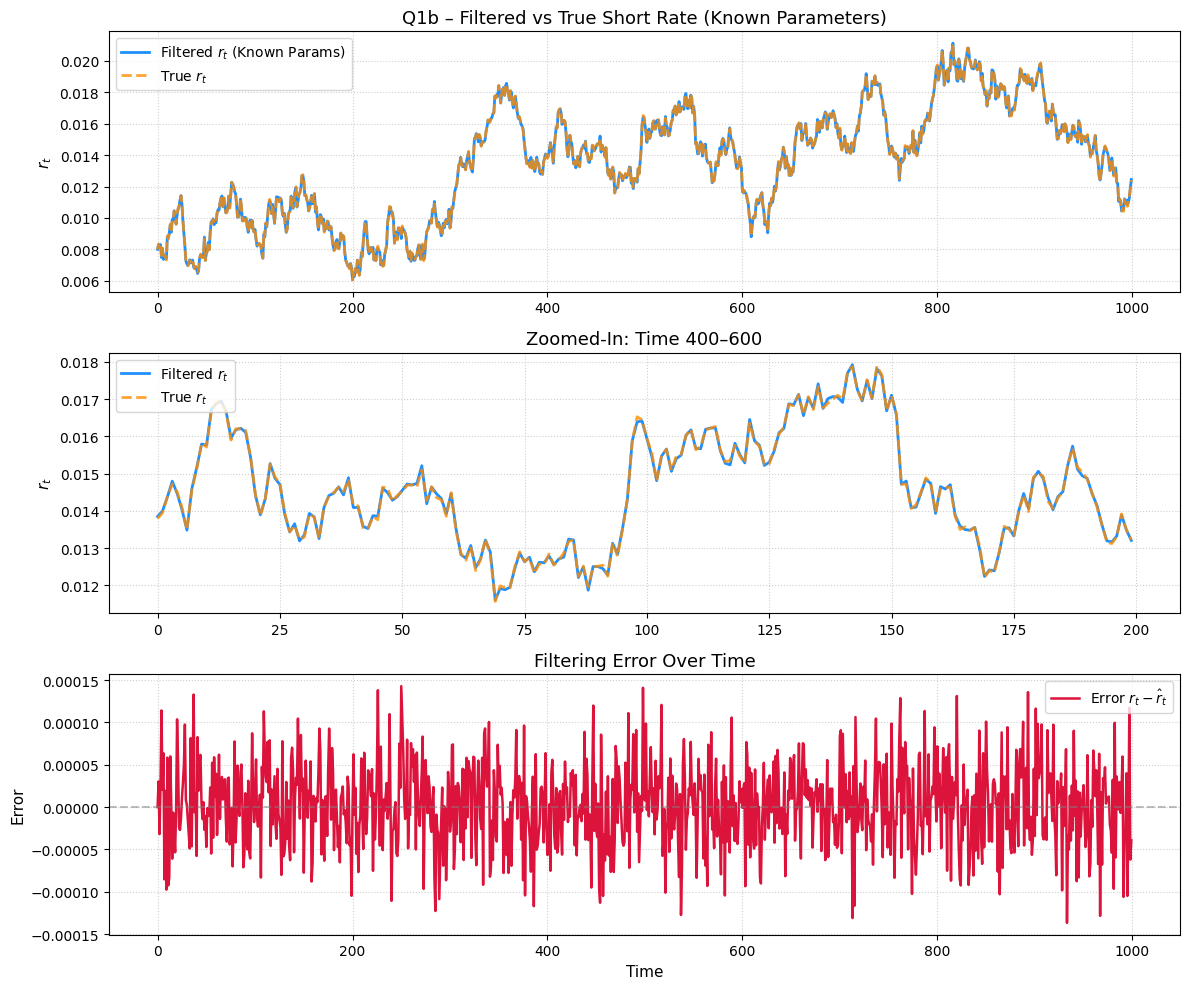

In [2]:
# Re-run Kalman filter using known parameters (from Q1a)
logL_known, r_filtered_known = kalmanFilter(
    yields_obs, a_vec, B_vec, H_mat, c_val, Phi, Q_val
)

# Compute error
error_known = r_t - r_filtered_known

# Plot: Full + Zoom + Error
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=False)

# --- 1. Full view ---
axs[0].plot(r_filtered_known, label='Filtered $r_t$ (Known Params)', color='dodgerblue', linewidth=2)
axs[0].plot(r_t, label='True $r_t$', linestyle='--', color='darkorange', linewidth=2, alpha=0.8)
axs[0].set_title('Q1b – Filtered vs True Short Rate (Known Parameters)', fontsize=13)
axs[0].set_ylabel('$r_t$', fontsize=11)
axs[0].grid(True, linestyle=':', alpha=0.6)
axs[0].legend(loc='upper left')

# --- 2. Zoomed-in region ---
axs[1].plot(r_filtered_known[400:600], label='Filtered $r_t$', color='dodgerblue', linewidth=2)
axs[1].plot(r_t[400:600], label='True $r_t$', linestyle='--', color='darkorange', linewidth=2, alpha=0.8)
axs[1].set_title('Zoomed-In: Time 400–600', fontsize=13)
axs[1].set_ylabel('$r_t$', fontsize=11)
axs[1].grid(True, linestyle=':', alpha=0.6)
axs[1].legend(loc='upper left')

# --- 3. Error plot ---
axs[2].plot(error_known, label='Error $r_t - \\hat{r}_t$', color='crimson', linewidth=1.8)
axs[2].set_title('Filtering Error Over Time', fontsize=13)
axs[2].set_xlabel('Time', fontsize=11)
axs[2].set_ylabel('Error', fontsize=11)
axs[2].grid(True, linestyle=':', alpha=0.6)
axs[2].legend(loc='upper right')
axs[2].axhline(y=0, linestyle='--', color='gray', alpha=0.5)

plt.tight_layout()
plt.show()



In [3]:
from scipy.optimize import minimize

# --- 1) MLE OBJECTIVE FUNCTION ---
def mle_objective(params, yields, maturities, sigma_y):
    alpha_P, theta_P, alpha_Q, theta_Q, sigma = params

    # Skip invalid values
    if any(p <= 0 for p in params):
        return np.inf

    # Step 1: compute A_tau and B_tau
    B_tau = (1 - np.exp(-alpha_Q * maturities)) / alpha_Q
    A_tau = ((theta_Q - (sigma ** 2) / (2 * alpha_Q ** 2)) * (B_tau - maturities)
             - (sigma ** 2) * (B_tau ** 2) / (4 * alpha_Q))

    # Step 2: compute Kalman Filter inputs
    a_vec = -A_tau / maturities
    B_vec = B_tau / maturities
    H_mat = np.diag([sigma_y ** 2] * len(maturities))
    Phi = np.exp(-alpha_P)
    c_val = theta_P * (1 - Phi)
    Q_val = np.sqrt((sigma ** 2) / (2 * alpha_P) * (1 - np.exp(-2 * alpha_P)))

    # Step 3: evaluate Kalman Filter log-likelihood
    logL, _ = kalmanFilter(yields, a_vec, B_vec, H_mat, c_val, Phi, Q_val)
    return logL  # we will minimize it

# --- 2) INITIAL GUESS AND BOUNDS ---
initial_params = [0.01, 0.01, 0.01, 0.01, 0.01]
bounds = [(1e-7, 1.0)] * 5  # lower and upper bounds for each parameter

# --- 3) RUN OPTIMIZATION ---
result = minimize(
    mle_objective,
    initial_params,
    args=(yields_obs, maturities, sigma_y),
    method='L-BFGS-B',
    bounds=bounds,
)

# --- 4) PRINT RESULTS ---
estimated_params = result.x
alpha_P_hat, theta_P_hat, alpha_Q_hat, theta_Q_hat, sigma_hat = estimated_params

print("Estimated Parameters:")
print(f"alpha_P = {alpha_P_hat:.6f}")
print(f"theta_P = {theta_P_hat:.6f}")
print(f"alpha_Q = {alpha_Q_hat:.6f}")
print(f"theta_Q = {theta_Q_hat:.6f}")
print(f"sigma   = {sigma_hat:.6f}")
print(f"Negative Log-Likelihood = {result.fun:.4f}")


Estimated Parameters:
alpha_P = 0.009934
theta_P = 0.015918
alpha_Q = 0.016968
theta_Q = 0.016007
sigma   = 0.000512
Negative Log-Likelihood = -49027.1130
